In [370]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,RobustScaler
import joblib

# Load dataset
data_df = pd.read_csv('games.csv')
print("Dataset shape:", data_df.shape)
data_df.info()

Dataset shape: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memor

In [371]:
# Rename columns for easier reference
data_df.columns = [
    'Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 
    'Number_of_Turns', 'Game_Status', 'Winner', 'Time_Increment',
    'White_ID', 'White_Rating', 'Black_ID',
    'Black_Rating', 'Moves',
    'Opening_Eco', 'Opening_Name', 'Opening_Ply'
]

In [372]:
print("Columns in DataFrame: \n",data_df.columns)
print("Info: \n",data_df.info)
print("NA Values: \n",data_df.isna().sum())
print("Null Values: \n",data_df.isnull().sum())

Columns in DataFrame: 
 Index(['Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 'Number_of_Turns',
       'Game_Status', 'Winner', 'Time_Increment', 'White_ID', 'White_Rating',
       'Black_ID', 'Black_Rating', 'Moves', 'Opening_Eco', 'Opening_Name',
       'Opening_Ply'],
      dtype='object')
Info: 
 <bound method DataFrame.info of         Game_ID  Rated_(T/F)    Start_Time      End_Time  Number_of_Turns  \
0      TZJHLljE        False  1.504210e+12  1.504210e+12               13   
1      l1NXvwaE         True  1.504130e+12  1.504130e+12               16   
2      mIICvQHh         True  1.504130e+12  1.504130e+12               61   
3      kWKvrqYL         True  1.504110e+12  1.504110e+12               61   
4      9tXo1AUZ         True  1.504030e+12  1.504030e+12               95   
...         ...          ...           ...           ...              ...   
20053  EfqH7VVH         True  1.499791e+12  1.499791e+12               24   
20054  WSJDhbPl         True  1.499698e+12  

### Simplification of Data

In [373]:
# Convert timestamps to raw numeric values in minutes
data_df['Start_Time'] = data_df['Start_Time'] / 60000
data_df['End_Time'] = data_df['End_Time'] / 60000

# Calculate 'Game_Duration' in minutes (no need to use .dt.total_seconds())
data_df['Game_Duration_(M)'] = data_df['End_Time'] - data_df['Start_Time']

# Handle cases with zero duration (if Start_Time == End_Time)
data_df.loc[data_df['Start_Time'] == data_df['End_Time'], 'Game_Duration_(M)'] = 1

# Remove rows where Game_Duration is 1 minute (assuming zero duration is invalid)
data_df = data_df[data_df['Game_Duration_(M)'] > 1]

# Remove rows where Game_Duration is divisible by 10
data_df = data_df[data_df['Game_Duration_(M)'] % 10 != 0]

# Remove duplicate rows based on 'Game_Duration' (keep=False removes all duplicates)
data_df = data_df[~data_df['Game_Duration_(M)'].duplicated(keep=False)]

# Round 'Game_Duration' to 2 decimal places
data_df['Game_Duration_(M)'] = data_df['Game_Duration_(M)'].round(2)


In [374]:
# 2. Calculate Elo Difference
data_df['Elo_Difference'] = data_df['White_Rating'] - data_df['Black_Rating']

In [375]:
# 3. Categorize Game Duration
def categorize_duration(duration):
    if duration < 300:  # Less than 5 minutes
        return 'Short'
    elif duration < 900:  # 5-15 minutes
        return 'Medium'
    else:
        return 'Long'

data_df['Duration_Category'] = data_df['End_Time'] - data_df['Start_Time']
data_df['Duration_Category'] = data_df['Duration_Category'].apply(categorize_duration)

In [376]:
# 4. Opening Analysis
data_df['Opening'] = data_df['Opening_Name']

In [377]:
# 5. Time per Move
data_df['Time_Per_Move_(S)'] = (data_df['Game_Duration_(M)'] * 60) / data_df['Number_of_Turns']
data_df['Time_Per_Move_(S)'] = data_df['Time_Per_Move_(S)'].round(2)

In [378]:
# 6. Elo Rating Tier
bins = [0, 1200, 1600, 2000, float('inf')]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
data_df['White_Rating_Tier'] = pd.cut(data_df['White_Rating'], bins=bins, labels=labels)
data_df['Black_Rating_Tier'] = pd.cut(data_df['Black_Rating'], bins=bins, labels=labels)


In [379]:
data_df['Time_Per_Move_(S)'].describe()

count     9655.000000
mean        22.024096
std        412.266146
min          2.250000
25%          8.020000
50%         11.070000
75%         16.165000
max      36174.600000
Name: Time_Per_Move_(S), dtype: float64

In [380]:
#Outlier Detection and Removal
Q1_duration = data_df['Game_Duration_(M)'].quantile(0.25)
Q3_duration = data_df['Game_Duration_(M)'].quantile(0.75)

Q1_time = data_df['Time_Per_Move_(S)'].quantile(0.25)
Q3_time = data_df['Time_Per_Move_(S)'].quantile(0.75)

# Calculate IQR for both columns
IQR_duration = Q3_duration - Q1_duration
IQR_time = Q3_time - Q1_time

# Define the lower and upper bounds for outliers
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

lower_bound_time = Q1_time - 1.5 * IQR_time
upper_bound_time = Q3_time + 1.5 * IQR_time

# Identify outliers in both columns
outliers_duration = data_df[(data_df['Game_Duration_(M)'] < lower_bound_duration) | (data_df['Game_Duration_(M)'] > upper_bound_duration)]
outliers_time = data_df[(data_df['Time_Per_Move_(S)'] < lower_bound_time) | (data_df['Time_Per_Move_(S)'] > upper_bound_time)]

# Combine both outliers (if any game is an outlier in either column, it's an outlier in the dataset)
outliers = pd.concat([outliers_duration, outliers_time]).drop_duplicates()

# Remove outliers from the main dataframe
data_df = data_df[~data_df.index.isin(outliers.index)]

# Save the outliers to a separate CSV file
# outliers.to_csv('outliers.csv', index=False)

In [381]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 'Number_of_Turns',
       'Game_Status', 'Winner', 'Time_Increment', 'White_ID', 'White_Rating',
       'Black_ID', 'Black_Rating', 'Moves', 'Opening_Eco', 'Opening_Name',
       'Opening_Ply', 'Game_Duration_(M)', 'Elo_Difference',
       'Duration_Category', 'Opening', 'Time_Per_Move_(S)',
       'White_Rating_Tier', 'Black_Rating_Tier'],
      dtype='object')

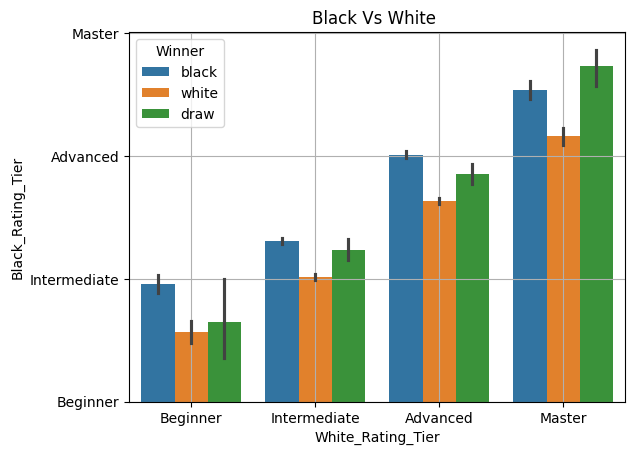

In [382]:
sns.barplot(data=data_df,x = "White_Rating_Tier", y = "Black_Rating_Tier", hue="Winner")
plt.title("Black Vs White ")
plt.grid(True)
plt.gca().invert_yaxis()

plt.show()

C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_17500\752029121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d",hue= None)


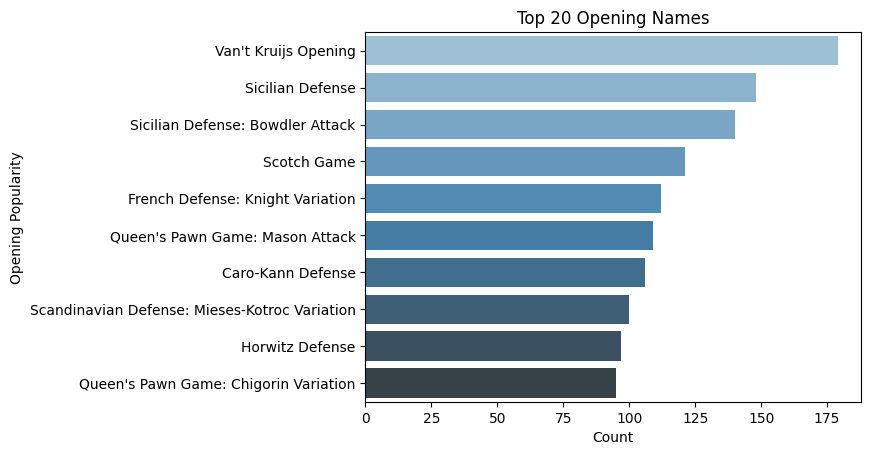

In [383]:
# Now, calculate the top 10 most frequent opening eco codes (or names)
top_openings = data_df['Opening'].value_counts().head(10)

# Create the bar plot for top openings
sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d",hue= None)
plt.title("Top 20 Opening Names")
plt.xlabel("Count")
plt.ylabel("Opening Popularity")
plt.show()

In [384]:
Winner = data_df['Opening']
Winner.to_csv('Winner.csv', index=False)

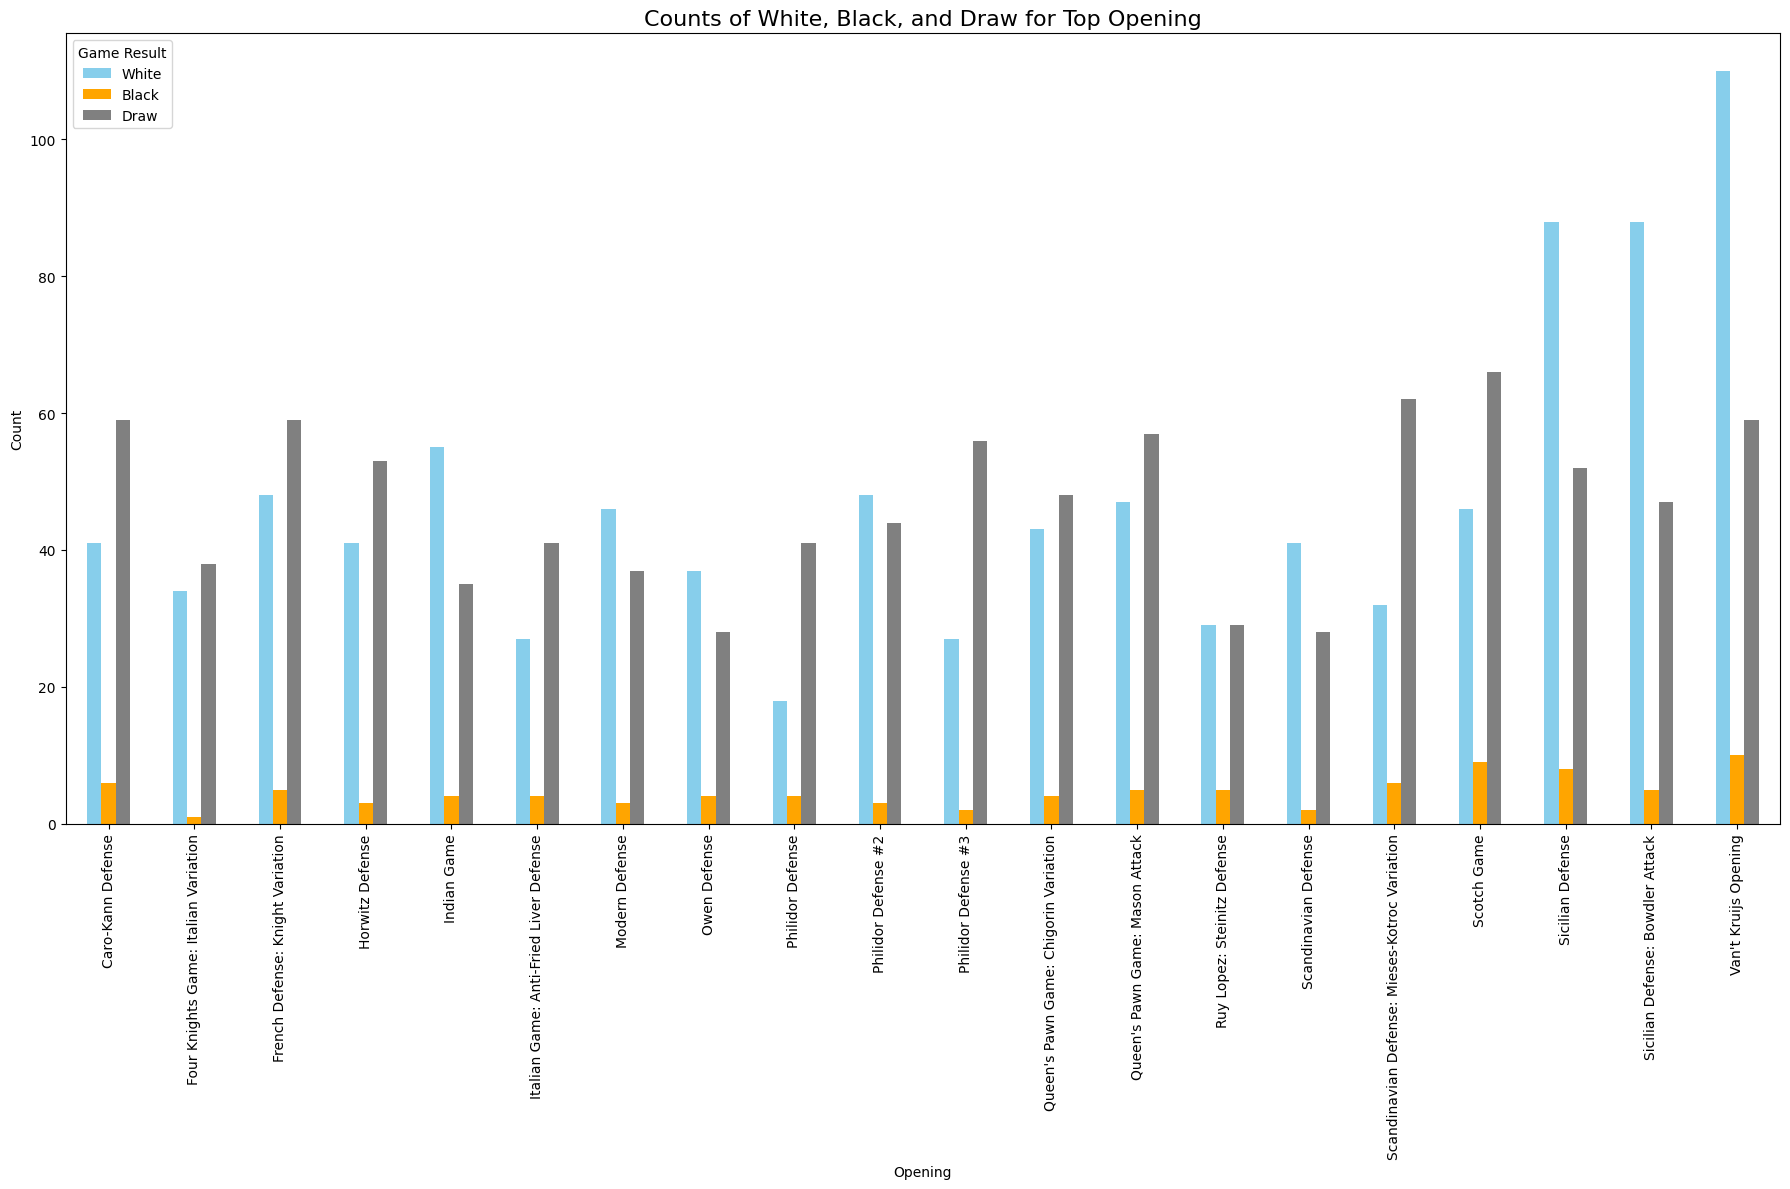

In [385]:
# Get the top 20 most common openings
top_openings = data_df['Opening'].value_counts().head(20).index

# Filter data for the top 20 openings
filtered_data = data_df[data_df['Opening'].isin(top_openings)]

# Group by 'Opening' and 'Winner' to count occurrences of 'white', 'black', and 'draw'
counts = filtered_data.groupby(['Opening', 'Winner']).size().unstack(fill_value=0)

# Plot the data
counts.plot(
    kind='bar', 
    figsize=(18, 12), 
    stacked=False,  # Separate bars for each result type
    color=['skyblue', 'orange', 'gray']  # Colors for white, black, and draw
)

# Add labels and title
plt.title('Counts of White, Black, and Draw for Top Opening', fontsize=16)
plt.xlabel('Opening')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.legend(title="Game Result", labels=['White', 'Black', 'Draw'])
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()


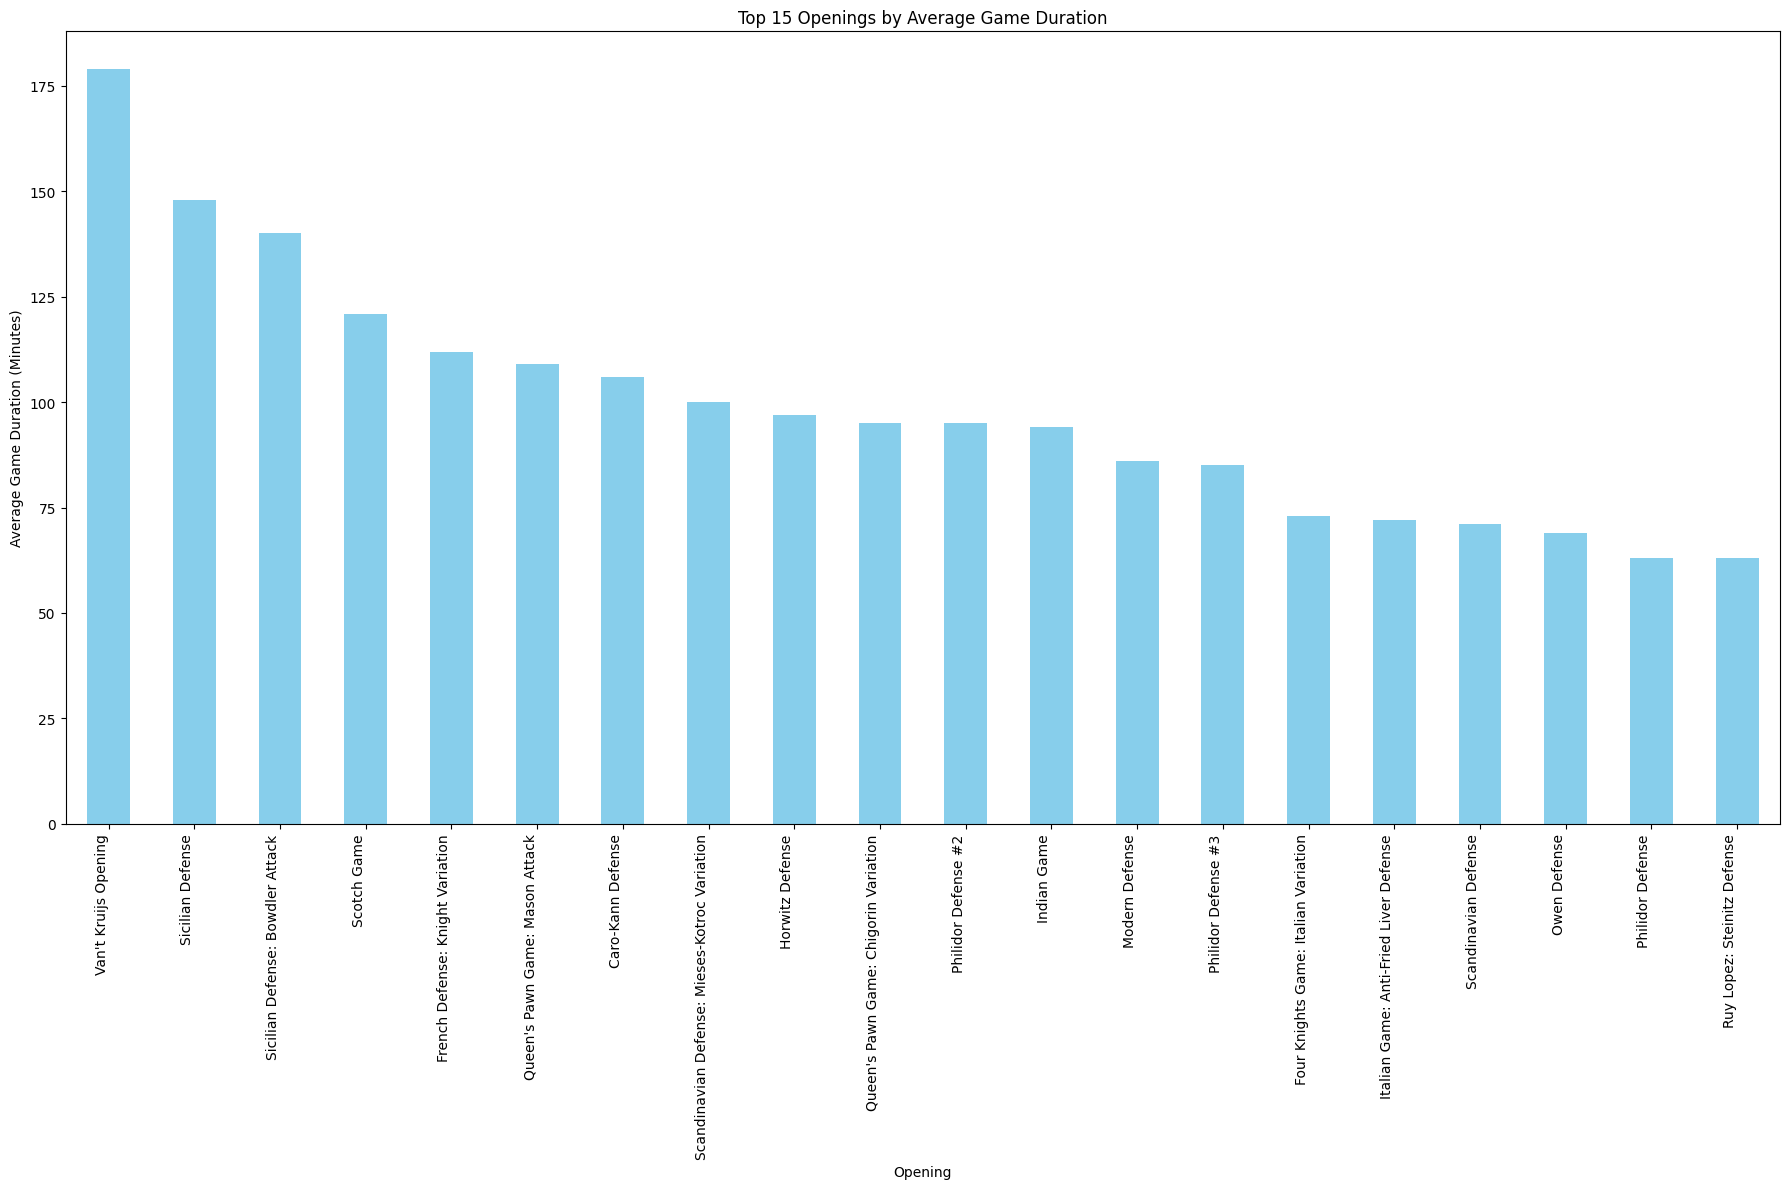

In [386]:
# Group by 'Opening' and calculate the mean of 'Game_Duration_(M)'
avg_duration = data_df.groupby('Opening')['Game_Duration_(M)'].mean().sort_values(ascending=False)

# Select the top 15 openings based on average game duration
top_15_openings = data_df['Opening'].value_counts().head(20)
# Plotting the bar chart
import matplotlib.pyplot as plt

top_15_openings.plot(kind='bar', figsize=(18, 12), color='skyblue')

# Add labels and title
plt.title('Top 15 Openings by Average Game Duration')
plt.xlabel('Opening')
plt.ylabel('Average Game Duration (Minutes)')

# Rotate x-axis labels to make them more readable
plt.xticks(rotation=90, ha='right')  # Rotate the labels by 45 degrees and align to the right
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()



In [387]:
# Count the occurrences of each opening
opening_counts = data_df['Opening'].value_counts()

# Top 10 most played openings
most_played_10 = opening_counts.head(10)

# Bottom 20 least played openings
least_played_20 = opening_counts.tail(20)

# Display the results
print("Top 10 Most Played Openings:")
print(most_played_10)

print("\nBottom 20 Least Played Openings:")
print(least_played_20)


Top 10 Most Played Openings:
Opening
Van't Kruijs Opening                             179
Sicilian Defense                                 148
Sicilian Defense: Bowdler Attack                 140
Scotch Game                                      121
French Defense: Knight Variation                 112
Queen's Pawn Game: Mason Attack                  109
Caro-Kann Defense                                106
Scandinavian Defense: Mieses-Kotroc Variation    100
Horwitz Defense                                   97
Queen's Pawn Game: Chigorin Variation             95
Name: count, dtype: int64

Bottom 20 Least Played Openings:
Opening
Sicilian Defense: Scheveningen Variation |  English Attack                       1
Queen's Gambit Declined: Slav |  Dutch Variation                                 1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation                     1
Semi-Bononi                                                                      1
Ruy Lopez: Morphy Defense |  Mode

In [388]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 'Number_of_Turns',
       'Game_Status', 'Winner', 'Time_Increment', 'White_ID', 'White_Rating',
       'Black_ID', 'Black_Rating', 'Moves', 'Opening_Eco', 'Opening_Name',
       'Opening_Ply', 'Game_Duration_(M)', 'Elo_Difference',
       'Duration_Category', 'Opening', 'Time_Per_Move_(S)',
       'White_Rating_Tier', 'Black_Rating_Tier'],
      dtype='object')

### Feature Enginerring

In [389]:
#Label Encoding
le = LabelEncoder()
encoded_moves = le.fit_transform(data_df['Moves'])
data_df['Moves_Encoded'] = encoded_moves

In [390]:
encoded_openings = le.fit_transform(data_df['Opening'])
data_df['Opening_Encoded'] = encoded_openings

In [391]:
# Correct way to select multiple columns from the DataFrame
Original_df = data_df[['Moves', 'Opening']]
# Original_df.to_csv('Removed.csv')

In [392]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 'Number_of_Turns',
       'Game_Status', 'Winner', 'Time_Increment', 'White_ID', 'White_Rating',
       'Black_ID', 'Black_Rating', 'Moves', 'Opening_Eco', 'Opening_Name',
       'Opening_Ply', 'Game_Duration_(M)', 'Elo_Difference',
       'Duration_Category', 'Opening', 'Time_Per_Move_(S)',
       'White_Rating_Tier', 'Black_Rating_Tier', 'Moves_Encoded',
       'Opening_Encoded'],
      dtype='object')

In [393]:
data_df.shape

(8723, 25)

# Metrics for Better Data
- Move Efficiency Score
- Acccuracy Metric
- Error Rate
- Tempo Efficiency
- Positional Exploitation Rate
- Game Duration Efficiency


C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_17500\1548184720.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.index, y=top_openings.values, palette='Blues_d')


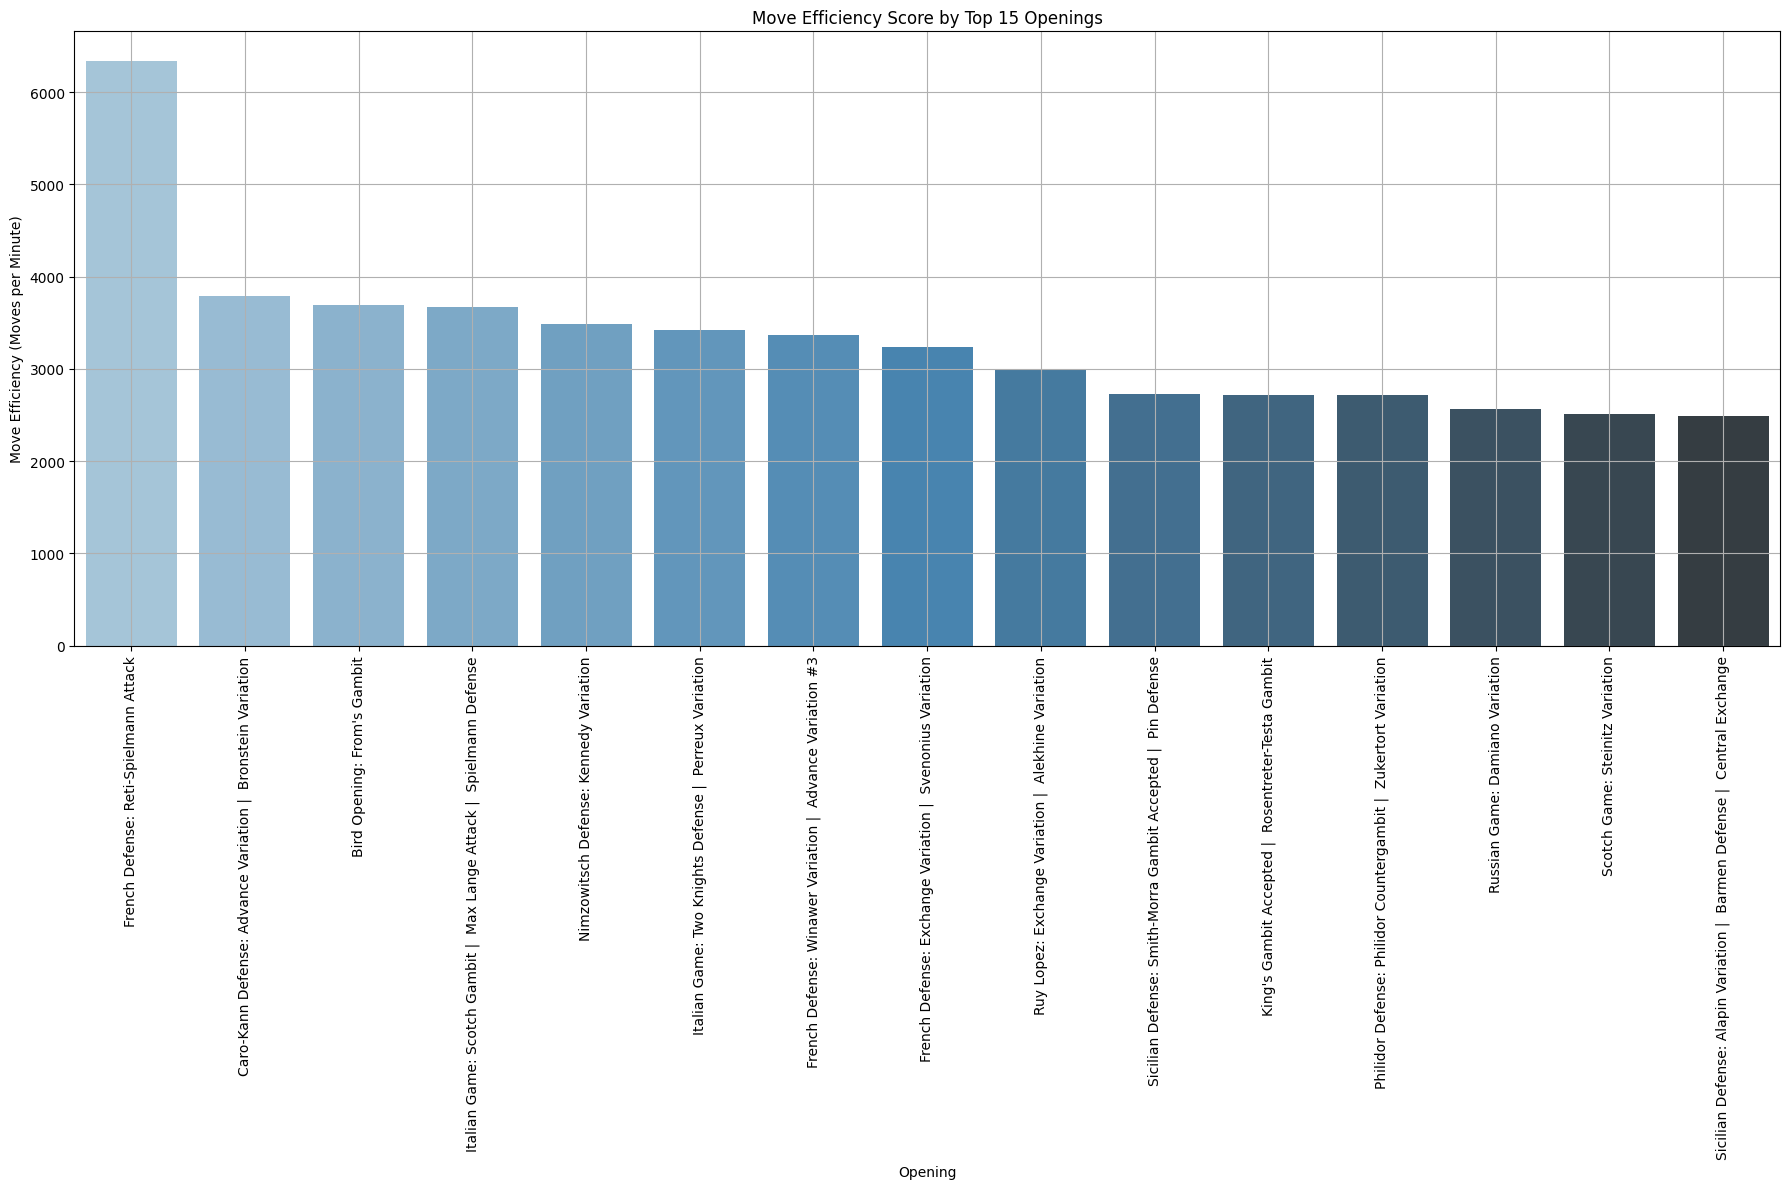

In [394]:
# Calculate Move Efficiency as Moves divided by Game Duration
data_df['Move_Efficiency_Score'] = data_df['Moves_Encoded'] / data_df['Game_Duration_(M)']
data_df['Move_Efficiency_Score'] = data_df['Move_Efficiency_Score'].round(2) 
# Aggregate Move Efficiency by Opening
opening_efficiency = data_df.groupby('Opening')['Move_Efficiency_Score'].mean().sort_values(ascending=False)
# Take the top 15 openings with the highest efficiency
top_openings = opening_efficiency.head(15)

# Plot Move Efficiency Score for top 15 openings
plt.figure(figsize=(18, 12))
sns.barplot(x=top_openings.index, y=top_openings.values, palette='Blues_d')
plt.title('Move Efficiency Score by Top 15 Openings')
plt.xlabel('Opening')
plt.grid(True)
plt.ylabel('Move Efficiency (Moves per Minute)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Move Efficiency Score for Top 15 Chess Openings

This chart represents the **Move Efficiency Score** for the top 15 chess openings, measured in moves per minute. Below is a breakdown of what this score means and the insights it offers:

### **Move Efficiency:**
- The **Move Efficiency Score** is calculated by dividing the number of moves in a game by the game duration (in minutes).
- This score helps indicate how quickly players are making their moves during games involving specific openings.

### **Top Openings:**
- **High Move Efficiency Scores** (e.g., *Bronstein Variation*) suggest that players made quicker moves. These games are typically shorter or involve faster decision-making.
- **Lower Move Efficiency Scores** (found on the right side of the chart) may point to longer games or more time-consuming moves, possibly indicating greater strategic complexity.

### **Interpretation:**
- Openings like **Bronstein Variation** or **Spielmann Defense** are associated with **higher move efficiency**, meaning they likely feature faster play, shorter games, or quicker decisions.
- Openings such as the **Russian Game: Damiano Variation** exhibit **lower move efficiency**, suggesting that these games might involve more deliberation, slower play, or strategic depth.

### **Conclusion:**
This visualization provides insights into how specific chess openings relate to the **pace of the game**:
- Openings with **higher move efficiency** tend to be fast-paced, while those with **lower move efficiency** could involve more strategic, longer games.
- This could also reveal trends in player behavior, showing how certain strategies lead to quicker decision-making or more in-depth analysis.


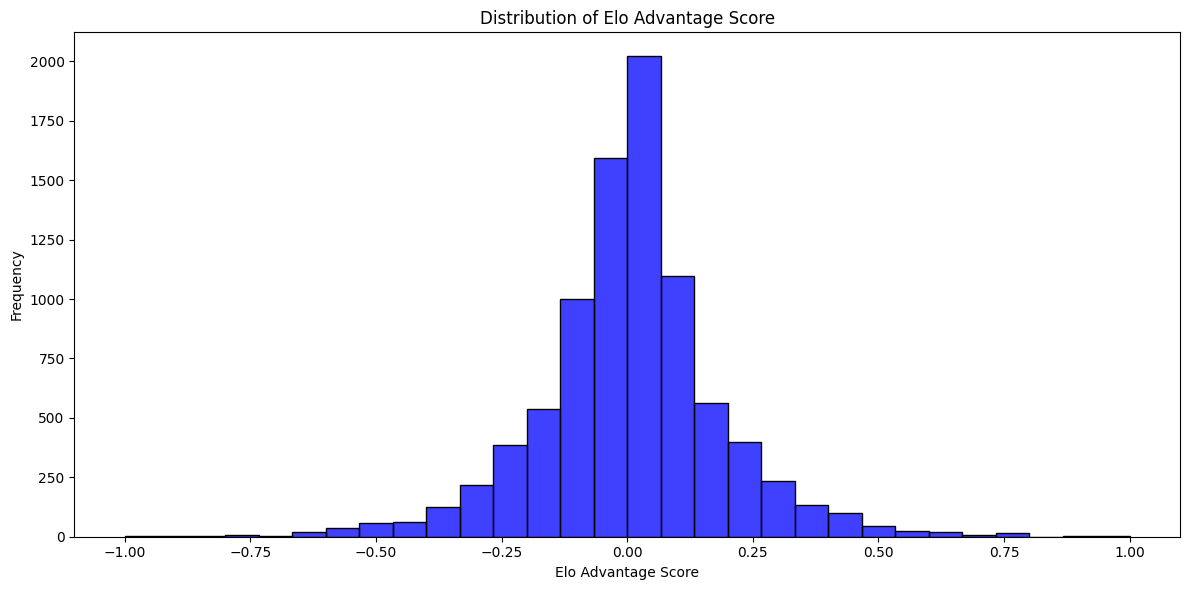

In [395]:
#Calculate Elo Advantage Score
data_df['Elo_Advantage_Score'] = data_df['Elo_Difference'] / abs(data_df['Elo_Difference']).max()
data_df['Elo_Advantage_Score'] =data_df['Elo_Advantage_Score'].round(2) 
# Plot Elo Advantage Score
plt.figure(figsize=(12, 6))
sns.histplot(data_df['Elo_Advantage_Score'], bins=30, color='blue')
plt.title('Distribution of Elo Advantage Score')
plt.xlabel('Elo Advantage Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


The dataset is mostly balanced, with a high concentration of games between players of similar Elo strength. This aligns with competitive platforms, where matchmaking tries to pair players of similar skill levels.

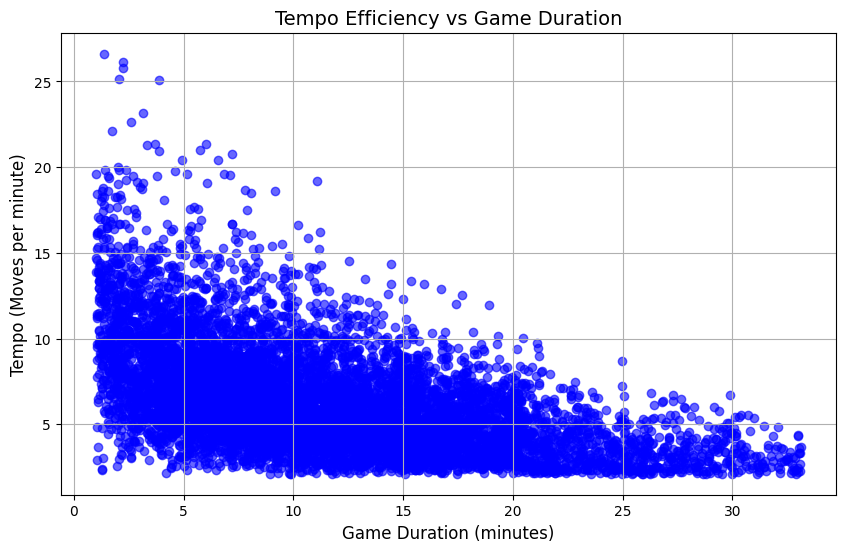

In [396]:
#Calculate GAME TEMPO
data_df['Tempo'] = data_df['Number_of_Turns'] / data_df['Game_Duration_(M)'].round(2) 
data_df['Tempo'] = data_df['Tempo'].round(2) 

plt.figure(figsize=(10,6))
plt.scatter(data_df['Game_Duration_(M)'], data_df['Tempo'], color='b', alpha=0.6)

# Adding title and labels
plt.title('Tempo Efficiency vs Game Duration', fontsize=14)
plt.xlabel('Game Duration (minutes)', fontsize=12)
plt.ylabel('Tempo (Moves per minute)', fontsize=12)

# Display the plot
plt.grid(True)
plt.show()

      Move_Efficiency  Time_Per_Move_(S)    PER
9288             3.27              18.32  17.85
9290             3.70              16.22  22.81
9292             6.29               9.54  65.93
9293             7.46               8.04  92.79
9294             4.06              14.78  27.47


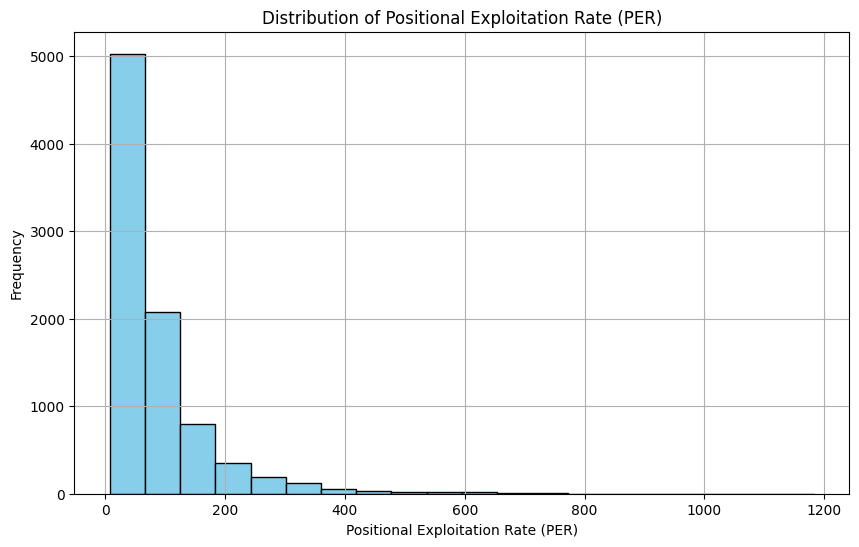

In [397]:
data_df['Move_Efficiency'] = data_df['Number_of_Turns'] / data_df['Game_Duration_(M)'].round(2)
data_df['Move_Efficiency'] = data_df['Move_Efficiency'].round(2) 
# Calculate the simplified Positional Exploitation Rate (PER)
data_df['PER'] = (data_df['Move_Efficiency'] / data_df['Time_Per_Move_(S)']) * 100
data_df['PER'] = data_df['PER'].round(2) 
# Display the PER values for analysis
print(data_df[['Move_Efficiency', 'Time_Per_Move_(S)', 'PER']].head())

plt.figure(figsize=(10, 6))
plt.hist(data_df['PER'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Positional Exploitation Rate (PER)')
plt.xlabel('Positional Exploitation Rate (PER)')
plt.grid(True)
plt.ylabel('Frequency')
plt.show()

       Game_ID  Number_of_Turns  Game_Duration_(M)   GDE
9288  FtVjeTvc               50              15.27  3.27
9290  SeWWAAH8               50              13.52  3.70
9292  ihAlSQ2i               21               3.34  6.29
9293  b21epG0r               20               2.68  7.46
9294  WiuVyh8F               43              10.59  4.06


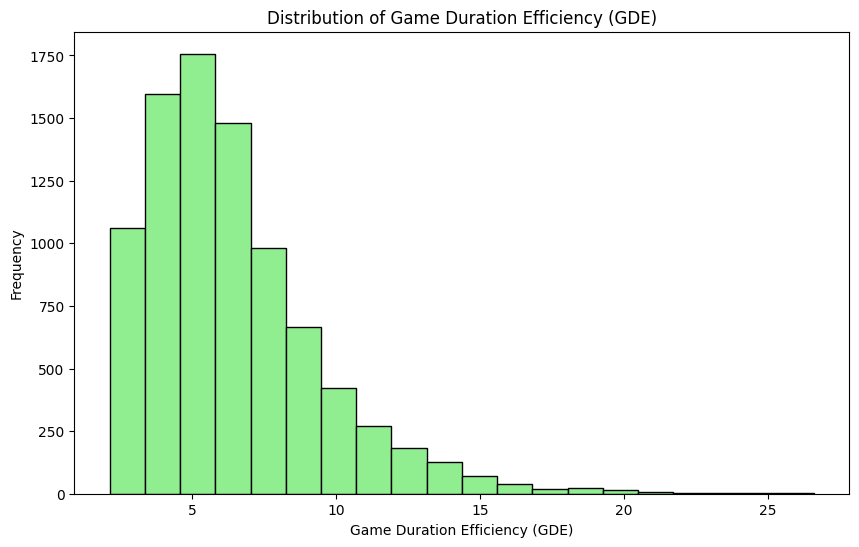

In [398]:
#Calculate Game Duration Efficiency
data_df['GDE'] = data_df['Number_of_Turns'] / data_df['Game_Duration_(M)']
data_df['GDE'] = data_df['GDE'].round(2) 
# Display the GDE values for analysis
print(data_df[['Game_ID', 'Number_of_Turns', 'Game_Duration_(M)', 'GDE']].head())

plt.figure(figsize=(10, 6))
plt.hist(data_df['GDE'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Game Duration Efficiency (GDE)')
plt.xlabel('Game Duration Efficiency (GDE)')
plt.ylabel('Frequency')
plt.show()

In [399]:
# Drop specific columns
data_df = data_df.drop(['Start_Time', 'End_Time','White_ID','Black_ID','White_Rating', 'Black_Rating','Opening_Name','Moves', 'Opening'], axis=1)

In [402]:
print(data_df.columns)
print(data_df.shape)

Index(['Game_ID', 'Rated_(T/F)', 'Number_of_Turns', 'Game_Status', 'Winner',
       'Time_Increment', 'Opening_Eco', 'Opening_Ply', 'Game_Duration_(M)',
       'Elo_Difference', 'Duration_Category', 'Time_Per_Move_(S)',
       'White_Rating_Tier', 'Black_Rating_Tier', 'Moves_Encoded',
       'Opening_Encoded', 'Move_Efficiency_Score', 'Elo_Advantage_Score',
       'Tempo', 'Move_Efficiency', 'PER', 'GDE'],
      dtype='object')
(8723, 22)


In [401]:
data_df.to_csv("Data1.csv")